# Model validation altimetry

Note: this notebook requires the model output data

<div class="alert alert-warning" role="alert">
  <strong>⚠️ Important Disclaimer</strong><br><br>
  This model setup is a <strong>simplified version</strong> of a detailed model developed by DHI. It does <strong>not</strong> resolve fine-scale processes and is <strong>not calibrated</strong> for operational use. Use is limited to <strong>educational and research purposes only</strong> — results should <strong>not</strong> inform decision-making. Performance shown here does <strong>not</strong> represent that of DHI’s high-resolution models.
</div>

### Load packages

In [1]:
import matplotlib.pyplot as plt
import modelskill as ms
import helper as h
import mikeio

In [9]:
obs_fldr = "../observations/" 
alt_fldr = "../observations/altimetry/"
mr_fldr = "../output/"    
#mr_fldr = "../output_sample/"     # use this if you have not downloaded the full data from Zenodo yet
mr_fn = f"{mr_fldr}Area.dfsu"

save_png = False if "sample" in mr_fldr else True

### Get altimetry obs

In [10]:
altlist = h.get_altimetry_obs()
altlist

[<TrackObservation>: 3a
 Time: 2022-01-01 10:56:44 - 2022-12-30 10:46:52
 Quantity: Significant Wave Height [meter],
 <TrackObservation>: 3b
 Time: 2022-01-01 10:17:30 - 2022-12-29 10:33:45
 Quantity: Significant Wave Height [meter],
 <TrackObservation>: 6a
 Time: 2022-01-01 20:26:32 - 2022-12-30 12:05:31
 Quantity: Significant Wave Height [meter],
 <TrackObservation>: c2
 Time: 2022-01-01 21:43:30.480000 - 2022-12-30 14:48:19.768000
 Quantity: Significant Wave Height [meter],
 <TrackObservation>: j3
 Time: 2022-01-01 20:26:03.960000 - 2022-12-30 18:50:34.393000
 Quantity: Significant Wave Height [meter],
 <TrackObservation>: sa
 Time: 2022-01-01 04:50:12.885000 - 2022-12-29 18:30:59.002000
 Quantity: Significant Wave Height [meter]]

### Model validation

In [11]:
# Exclude the first two days of 2022 to avoid spin-up effects
mr = ms.DfsuModelResult(mikeio.read(mr_fn,time=slice("2022-01-03","2022-12-31"))[0], name="MIKE21")

<DfsuModelResult>: MIKE21
Time: 2022-01-03 00:00:00 - 2022-12-31 23:00:00
Quantity: Significant wave height [m]

In [12]:
cmps = []
match_t = "2022" # You can choose a specific time period here
for o in altlist:
    print(f"Processing {o.name}...")
    try:
        cmp = ms.match(obs=o.sel(time=match_t), mod=mr) 
        cmps.append(cmp.remove_bias())
    except Exception as e:
        print(e)    
cc = ms.ComparerCollection(cmps)

Processing 3a...
Processing 3b...
Processing 6a...
Processing c2...
Processing j3...
Processing sa...


### Error table

In [13]:
cc.skill().round(4)

,n,bias,rmse,urmse,mae,cc,si,r2
observation,,,,,,,,
3a,13803,-0.0,0.3012,0.3012,0.2294,0.9654,0.1979,0.9091
3b,14465,0.0,0.3324,0.3324,0.2459,0.9498,0.2279,0.8771
6a,18315,-0.0,0.2857,0.2857,0.2170,0.9611,0.1957,0.9094
c2,13542,0.0,0.3171,0.3171,0.2422,0.9616,0.2078,0.8869
j3,16264,0.0,0.3085,0.3085,0.2364,0.9568,0.1988,0.8964
sa,12533,-0.0,0.2989,0.2989,0.2218,0.9679,0.1936,0.9066


### Scatter plots

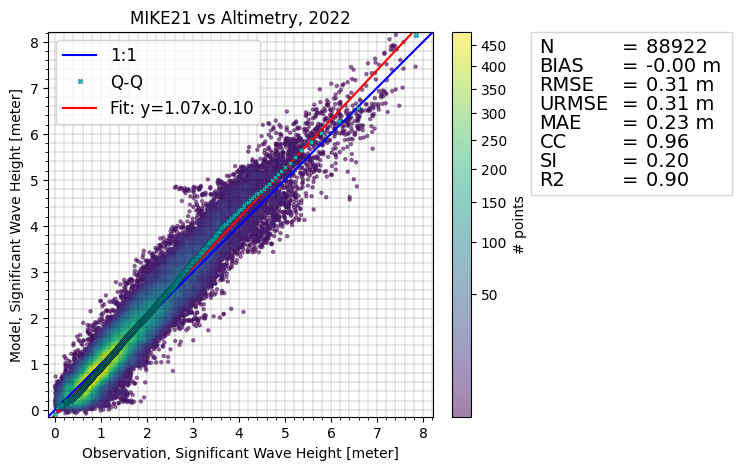

In [14]:
cc.plot.scatter(skill_table=True, show_points=True, figsize=(6,5))
plt.title("MIKE21 vs Altimetry, "+match_t)
if save_png: 
    plt.savefig("../figures/altimetry_comparison.png", bbox_inches="tight")

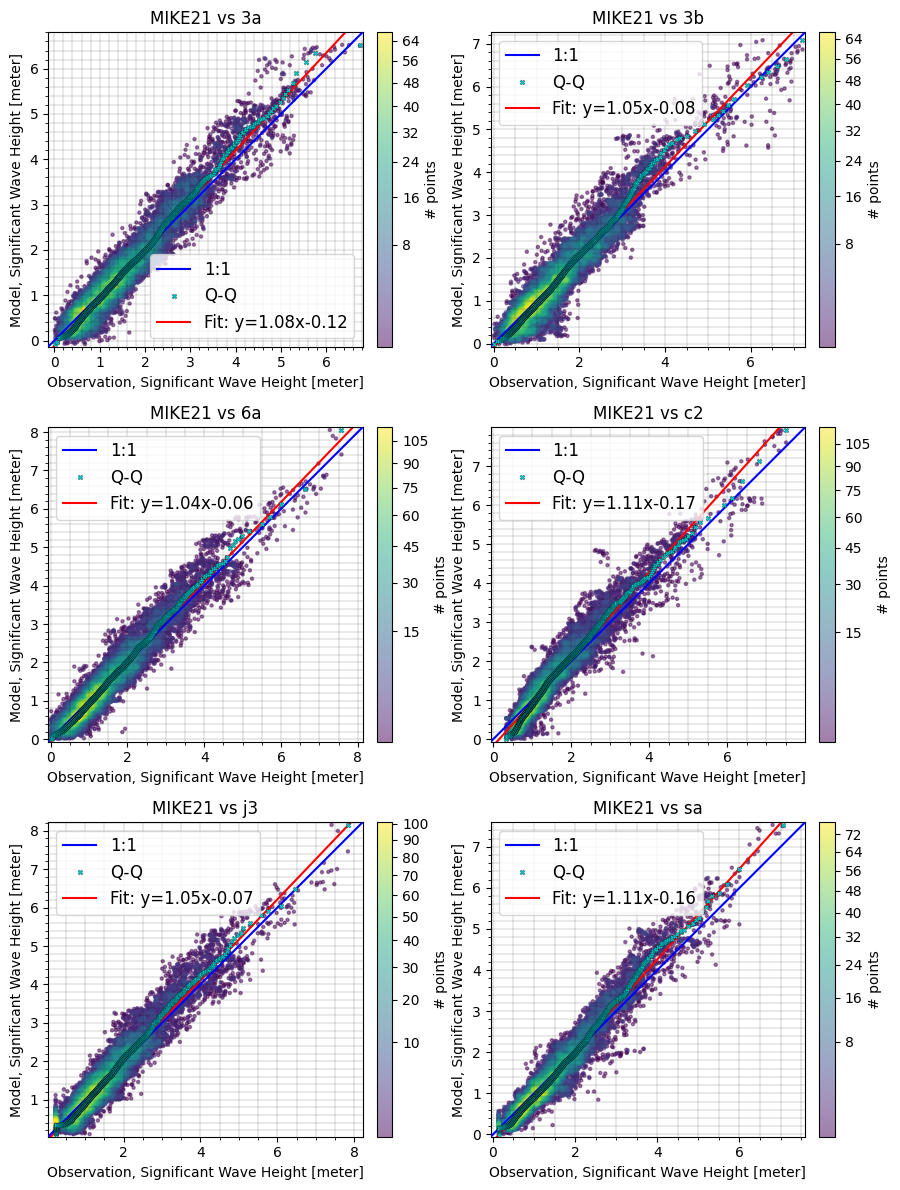

In [15]:
fig, axs = plt.subplots(-(-len(cc)//2), 2, figsize=(9,len(cc)*2))
axs = axs.flatten()
for i in range(len(cc)):
    cc[i].sel().plot.scatter(ax=axs[i], show_points=True)

if len(cc) % 2 != 0:
    axs[-1].axis("off")
plt.tight_layout()
plt.show()